<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/Hiroshima_Univ_Topic_Modeling_HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第1回AI・データイノベーションセミナー 2021年3月11日（木曜日）
# ハンズオンで学ぶトピックモデルによるテキストマイニング

* トピックモデリングを、NMF(nonnegative matrix factorization)とLDA(latent Dirichlet allocation)とで実践してみる。
 * どちらも、大量の文書に含まれる様々な話題（トピック）を、各話題を端的に表す単語のリストとして、抽出できる手法。
* いずれも、機械学習ライブラリscikit-learnの実装を使う。
 * LDAについては、gensimというライブラリの実装も紹介する。
* 各トピックの上位単語はワードクラウドで可視化する。

* 参考資料
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html



---



## 1 データセットの準備


### 日本語のデータセットを使う場合のための準備

In [ ]:
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

* エラーが出たらランタイムを再起動するなどしてみる。

In [ ]:
!ls /usr/share/fonts/truetype/fonts-japanese-gothic.ttf

In [3]:
!pip install fugashi[unidic]
!python -m unidic download

download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic.zip
Dictionary version: 2.3.0+2020-10-08
unidic.zip: 100% 608M/608M [00:07<00:00, 83.0MB/s]
Finished download.
Downloaded UniDic v2.3.0+2020-10-08 to /usr/local/lib/python3.7/dist-packages/unidic/dicdir


### 今回使うデータセット
* （英語）NeurIPSで発表された1,740本の論文の本文
 * https://cs.nyu.edu/~roweis/data.html
* （日本語）ライブドアニュースの記事
 * https://www.rondhuit.com/download.html

### データをダウンロードしリスト化する関数を定義

* PATHで指定した場所に文書ファイルが配置される。
* 自前のデータを使う場合は、

In [4]:
import io
import os.path
import re
import tarfile
import smart_open


#URL = 'https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'
URL = 'https://www.rondhuit.com/download/ldcc-20140209.tar.gz'


PATH = '/content/drive/MyDrive/data/' # ここは適当に設定


def extract_documents(url=URL):

  fname = os.path.join(PATH, url.split('/')[-1])

  if not os.path.isfile(fname):
    with smart_open.open(url, "rb") as fin:
      with smart_open.open(fname, 'wb') as fout:
        while True:
          buf = fin.read(io.DEFAULT_BUFFER_SIZE)
          if not buf:
            break
          fout.write(buf)

  with tarfile.open(fname, mode='r:gz') as tar:
    # 解凍することでテキストファイルがたくさん作られるようになっていればよい
    files = [
             m for m in tar.getmembers()
             #if m.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', m.name)
             if m.isfile() and re.search(r'text/[-\w]+/[\-a-z0-9]+.txt', m.name)
             ]
    for member in sorted(files, key=lambda x: x.name):
      member_bytes = tar.extractfile(member).read()
      yield member_bytes.decode('utf-8', errors='replace')

* 実際にデータを取得しリスト化する

In [5]:
docs = list(extract_documents())

* 文書数、具体的な文書の内容などを確認

In [6]:
print(len(docs))

7367


In [7]:
print(docs[0][:1000])

http://news.livedoor.com/article/detail/4778030/
2010-05-22T14:30:00+0900
友人代表のスピーチ、独女はどうこなしている？
　もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？　さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。

　「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」

　さてそんなとき、独女はどう対応したらいいか？

　最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。

　「一晩で3人位の人が添削してくれましたよ。ちなみに自分以外にもそういう人はたくさんいて、その相談サイトには同じように添削をお願いする投稿がいっぱいありました」（由利さん）。ためしに教えてもらったそのサイトをみてみると、確かに「結婚式のスピーチの添削お願いします」という投稿が1000件を超えるくらいあった。めでたい結婚式の影でこんなネットコミュニティがあったとは知らなかった。

　しかし「事前にお願いされるスピーチなら準備ができるしまだいいですよ。一番嫌なのは何といってもサプライズスピーチ！」と語るのは昨年だけで10万以上お祝いにかかったというお祝い貧乏独女の薫さん（35歳）

　「私は基本的に人前で話すのが苦手なんですよ。だからいきなり指名されるとしどろもどろになって何もいえなくなる。そうすると自己嫌悪に陥って終わった後でもまったく楽しめなくなりますね」
　
　サプライズスピーチのメリットとしては、準備していない状態なので、フランクな本音をしゃべってもらえるという楽しさがあるようだ。しかしそれも上手に対応できる人なら

### spaCyを使ってtokenizeする
* spaCyについては https://spacy.io/ を参照

* 前処理の高速化のためtaggerなどは無効にしておく

In [8]:
import spacy
nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

from spacy.lang.ja import Japanese
nlp = Japanese()

* テキストを小文字にしてからtokenizeする関数の定義

In [9]:
def spacy_lemmatize_text(nlp, text):
  text = nlp(text.lower())
  doc = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text]
  doc = [word for word in doc if len(word) > 1] # 長さ1の単語は削除
  return doc 

* tokenizationの実行

In [10]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs[:1000]):
  new_docs.append(spacy_lemmatize_text(nlp, doc))

100%|██████████| 1000/1000 [00:21<00:00, 45.65it/s]


* tokenizationの結果を確認

In [11]:
print(new_docs[0])

['ｈｔｔｐ：／／', 'ニュース-news', 'livedoor', 'コム-com', 'アーティクル-article', 'ディテール-detail', '4778030', '2010', '05', '22', '14', '30', '00', '0900', '友人', '代表', 'スピーチ-speech', '独女', 'どう', '熟す', '居る', 'もう', '直ぐ', 'ジューン-June', 'ブライド-bride', '呼ぶ', 'れる', '独女', '自分', '未だ', '呼ぶ', 'れる', 'ばかり', '言う', '祝い', '貧乏', '状態', '多い', '無い', '更に', '出席', '回数', '重ねる', '行く', 'こんな', '願い事', '為る', 'れる', '少ない', '無い', '願い', '有る', 'けれど', '友人', '代表', 'スピーチ-speech', '遣る', '呉れる', 'ない', 'そんな', '独女', 'どう', '対応', '為る', '良い', '最近', 'インターネット-internet', '検索', '為る', '友人', '代表', 'スピーチ-speech', '例文', 'サイト-site', '沢山', '出る', '来る', '其れ', '参考', '為る', '無難', '作成', '出来る', '然し', 'ユリ', 'さん', '33', 'ネット-net', '参考', '為る', '作成', '為る', '此れ', '本当', '良い', '不安', 'です', '独り暮らし', '聞く', 'せる', '感想', '言う', '呉れる', '居る', 'ない', '言う', '友人', '態々', '聞く', 'せる', 'どう', '思う', '言う', '活用', '為る', 'インターネット-internet', '悩み', '相談', 'サイト-site', '其処', '作成', '為る', 'スピーチ-speech', '掲載', '為る', '此れ', '大丈夫', '添削', '為る', '下さる', 'メッセージ-message', '送る', '言う', '有る', 'くらい', '添削', '為る', '

* 各文書を長い文字列で表しなおす（後でCountVectorizerを使うため）

In [12]:
corpus = [' '.join(doc) for doc in new_docs]

In [13]:
corpus[0]

'ｈｔｔｐ：／／ ニュース-news livedoor コム-com アーティクル-article ディテール-detail 4778030 2010 05 22 14 30 00 0900 友人 代表 スピーチ-speech 独女 どう 熟す 居る もう 直ぐ ジューン-June ブライド-bride 呼ぶ れる 独女 自分 未だ 呼ぶ れる ばかり 言う 祝い 貧乏 状態 多い 無い 更に 出席 回数 重ねる 行く こんな 願い事 為る れる 少ない 無い 願い 有る けれど 友人 代表 スピーチ-speech 遣る 呉れる ない そんな 独女 どう 対応 為る 良い 最近 インターネット-internet 検索 為る 友人 代表 スピーチ-speech 例文 サイト-site 沢山 出る 来る 其れ 参考 為る 無難 作成 出来る 然し ユリ さん 33 ネット-net 参考 為る 作成 為る 此れ 本当 良い 不安 です 独り暮らし 聞く せる 感想 言う 呉れる 居る ない 言う 友人 態々 聞く せる どう 思う 言う 活用 為る インターネット-internet 悩み 相談 サイト-site 其処 作成 為る スピーチ-speech 掲載 為る 此れ 大丈夫 添削 為る 下さる メッセージ-message 送る 言う 有る くらい 添削 為る 呉れる ます 因み 自分 以外 そう 言う 沢山 居る 其の 相談 サイト-site 同じ 添削 願う 為る 投稿 一杯 有る ます ユリ さん 試し 教える 貰う 其の サイト-site 見る 見る 確か 結婚 スピーチ-speech 添削 願う 為る ます 言う 投稿 1000 越える くらい 有る めでたい 結婚 こんな ネット-net コミュニティー-community 有る 知る ない 然し 事前 願う 為る れる スピーチ-speech 準備 出来る 未だ 良い です 一番 言う サプライズ-surprise スピーチ-speech 語る 昨年 だけ 10 以上 祝い 掛かる 言う 祝い 貧乏 独女 カオル さん 35 私-代名詞 基本 人前 話す 苦手 です から 行成 指名 為る れる しどろもどろ 成る 言う ない 成る そう 為る 自己 嫌悪 陥る 終わる 全く 楽しむ ない 成る ます サプ

## 2 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の1/4より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.25, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus)

In [15]:
print(X[0])

  (0, 27)	1
  (0, 5)	1
  (0, 29)	1
  (0, 1915)	6
  (0, 1588)	3
  (0, 2982)	1
  (0, 3108)	1
  (0, 2015)	2
  (0, 2750)	2
  (0, 724)	1
  (0, 3524)	2
  (0, 3002)	2
  (0, 2717)	1
  (0, 1777)	1
  (0, 2037)	1
  (0, 3696)	1
  (0, 663)	3
  (0, 2250)	1
  (0, 3790)	1
  (0, 2229)	2
  (0, 815)	2
  (0, 321)	2
  (0, 2789)	2
  (0, 956)	4
  (0, 526)	4
  :	:
  (0, 1359)	2
  (0, 2524)	2
  (0, 2352)	1
  (0, 696)	1
  (0, 742)	1
  (0, 2473)	1
  (0, 2721)	2
  (0, 2101)	1
  (0, 2066)	1
  (0, 3494)	1
  (0, 1455)	1
  (0, 1432)	1
  (0, 3454)	1
  (0, 2494)	1
  (0, 2137)	1
  (0, 3813)	1
  (0, 634)	1
  (0, 3262)	1
  (0, 1751)	1
  (0, 2360)	1
  (0, 661)	1
  (0, 3782)	1
  (0, 2554)	1
  (0, 2358)	1
  (0, 1335)	1


In [16]:
print(vectorizer.get_feature_names()[1000:1100])

['ジャンル', 'ジュリ', 'ジュン', 'ジュンコ', 'ジョーヌ', 'スカート', 'スキル', 'スキン', 'スクール', 'スケジュール', 'スズキ', 'スタイリッシュ', 'スタイル', 'スタッフ', 'スタンス', 'スター', 'スタート', 'ストア', 'ストレス', 'ストレージ', 'ストレート', 'ストーリー', 'スピリチュアル', 'スピリット', 'スピード', 'スペシャル', 'スペース', 'スポット', 'スポーツ', 'スマホ', 'スマート', 'スムーズ', 'スリム', 'スルー', 'スーツ', 'スーパー', 'セイコ', 'セキュリティー', 'セクシー', 'セックス', 'セット', 'セツコ', 'セラー', 'セレブ', 'センス', 'センター', 'センチ', 'センチメートル', 'センチュリー', 'センド', 'ゼロ', 'ソニー', 'ソフト', 'ソン', 'ソーシャル', 'ソース', 'ゾーン', 'タイトル', 'タイプ', 'タイミング', 'タイム', 'タオル', 'タカコ', 'タケシ', 'タッチ', 'タバコ', 'タブレット', 'タレント', 'タロット', 'タンク', 'ターゲット', 'ダイエット', 'ダウンロード', 'ダンス', 'チェック', 'チェンジ', 'チエ', 'チャレンジ', 'チャンス', 'チャンネル', 'チョコ', 'チーム', 'ツアー', 'ツイッター', 'ツイート', 'ツー', 'ツール', 'テクニック', 'テスト', 'テレビ', 'テンション', 'テーブル', 'テーマ', 'ディスプレー', 'ディズニー', 'デザイナー', 'デザイン', 'デザート', 'デジ', 'デジタル']


In [17]:
print(len(vectorizer.get_feature_names()))

3855


* 文書数と語彙サイズを変数にセット

In [18]:
X.shape

(1000, 3855)

In [19]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [21]:
print(Xtfidf[0])

  (0, 3813)	0.06845690064180608
  (0, 3791)	0.1640707176239459
  (0, 3790)	0.0750590618577362
  (0, 3782)	0.04699818050337762
  (0, 3778)	0.05179208102321167
  (0, 3739)	0.07313115217092404
  (0, 3696)	0.059465615867121985
  (0, 3601)	0.04947968021286114
  (0, 3552)	0.05921401204308614
  (0, 3524)	0.13876432365602942
  (0, 3494)	0.04407390592591466
  (0, 3489)	0.04465637634952217
  (0, 3476)	0.06558991175073905
  (0, 3472)	0.0852894885697072
  (0, 3454)	0.06675525246327113
  (0, 3380)	0.06193194859993217
  (0, 3355)	0.17403916295940297
  (0, 3324)	0.056058484716699476
  (0, 3262)	0.07313115217092404
  (0, 3232)	0.053605332959954226
  (0, 3141)	0.08629728947941204
  (0, 3116)	0.09564579253764798
  (0, 3108)	0.044755587426407575
  (0, 3006)	0.05921401204308614
  (0, 3002)	0.10358416204642334
  :	:
  (0, 933)	0.07725680491801713
  (0, 859)	0.1529791685869923
  (0, 815)	0.11696497857051524
  (0, 757)	0.037793598631335364
  (0, 746)	0.0852894885697072
  (0, 742)	0.04058406715960457
  (0, 72

In [22]:
Xtfidf.shape

(1000, 3855)

* 抽出するトピックの個数は、今回は20個とする。

In [23]:
n_components = 20

## 3 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードを参考にした。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [24]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [25]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, 
          beta_loss='kullback-leibler', solver='mu',
          tol=0.00001,
          alpha=.1,
          l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=1000 and n_features=3855
Epoch 10 reached after 0.860 seconds, error: 207.904394
Epoch 20 reached after 1.615 seconds, error: 207.462392
Epoch 30 reached after 2.368 seconds, error: 207.322335
Epoch 40 reached after 3.120 seconds, error: 207.236538
Epoch 50 reached after 3.853 seconds, error: 207.183083
Epoch 60 reached after 4.594 seconds, error: 207.152041
Epoch 70 reached after 5.330 seconds, error: 207.129819
Epoch 80 reached after 6.057 seconds, error: 207.115594
Epoch 90 reached after 6.789 seconds, error: 207.103587
Epoch 100 reached after 7.528 seconds, error: 207.093770
Epoch 110 reached after 8.265 seconds, error: 207.085644
Epoch 120 reached after 8.986 seconds, error: 207.077656
Epoch 130 reached after 9.717 seconds, error: 207.071912
Epoch 140 reached after 10.470 seconds, error: 207.066742
Epoch 150 reached after 11.210 seconds, error: 207.054125
Epoch 160 reached after 11.944 

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [26]:
nmf.components_

array([[0.00000000e+00, 3.76744613e-02, 3.34481570e-02, ...,
        0.00000000e+00, 0.00000000e+00, 7.89919418e-03],
       [0.00000000e+00, 4.67230195e-03, 3.51951872e-03, ...,
        2.07372928e-03, 0.00000000e+00, 0.00000000e+00],
       [1.04283330e-02, 2.49645214e-02, 9.68421382e-02, ...,
        2.55673370e-01, 1.72843240e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 3.84600989e-03, 3.65962284e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.21142377e-02, 3.75991003e-03, 2.80099394e-02, ...,
        3.97418665e-15, 2.96590214e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.25176046e-02, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [27]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [28]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [29]:
print(top_words[0])

['友人', '仮名', '時代', '世代', '語る', 'みたい', '言葉', '若い', '年齢', 'タイプ', 'type', '職場', 'ばかり', 'ちゃう', '周囲', 'らしい', '確か', '一方', '32', '感じ', '35', '違う', '社員', 'こう', '可愛い', '34', '呼ぶ', '33', '36', '彼氏']


In [30]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [31]:
topic_words[0]

{'32': 0.18695550382780285,
 '33': 0.1661108663740881,
 '34': 0.17224339823139026,
 '35': 0.18387948212080735,
 '36': 0.16116543800112132,
 'type': 0.203792037883582,
 'こう': 0.17554862055043666,
 'ちゃう': 0.19318491086009396,
 'ばかり': 0.20031686991984907,
 'みたい': 0.22906731190012428,
 'らしい': 0.18804034278313103,
 'タイプ': 0.203792037883582,
 '一方': 0.18735166871335518,
 '世代': 0.23212248755140216,
 '仮名': 0.2922068043435817,
 '友人': 0.3085426968049098,
 '可愛い': 0.17385078071137536,
 '周囲': 0.19293149935161502,
 '呼ぶ': 0.1675273711190894,
 '年齢': 0.21250151848893747,
 '彼氏': 0.16084477179914913,
 '感じ': 0.18623765053201016,
 '時代': 0.27845812636851813,
 '確か': 0.18761225296580905,
 '社員': 0.17607589883407457,
 '職場': 0.20271880899617079,
 '若い': 0.21263426208044608,
 '言葉': 0.21265375097922962,
 '語る': 0.22918784278996723,
 '違う': 0.17772418030498005}

### 重要語をワードクラウドで可視化

In [32]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [33]:
print(STOPWORDS)

{'above', 'after', 'having', 'why', 'only', 'doing', 'for', 'this', "you're", "they'll", 'else', "she's", 'if', 'of', 'by', 'cannot', "didn't", 'be', 'can', "here's", 'other', "she'll", 'at', "shouldn't", 'such', 'me', "can't", 'had', 'both', "they'd", "aren't", "isn't", "mustn't", 'just', 'where', "we'll", 'once', 'all', "don't", 'her', 'more', 'an', 'the', "he'd", 'from', 'on', 'theirs', 'which', 'as', 'then', 'through', "when's", 'have', "won't", 'out', 'our', 'than', 'are', 'ours', 'about', "i've", "we've", 'however', "let's", 'ought', 'there', "what's", 'up', 'was', 'ever', 'before', 'myself', "wouldn't", 'further', 'here', 'most', 'your', 'but', 'themselves', "they're", 'very', 'get', 'itself', 'also', 'his', 'shall', 'http', 'am', 'what', 'off', "wasn't", "you'll", "where's", 'again', 'they', 'him', "hadn't", 'would', "he's", "that's", 'yours', 'until', "couldn't", 'it', 'that', 'any', "he'll", 'i', 'he', 'does', "it's", 'is', "she'd", "there's", 'these', "hasn't", 'you', 'being

* ワードクラウドを描画

In [34]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                  colormap='tab10'
                  )

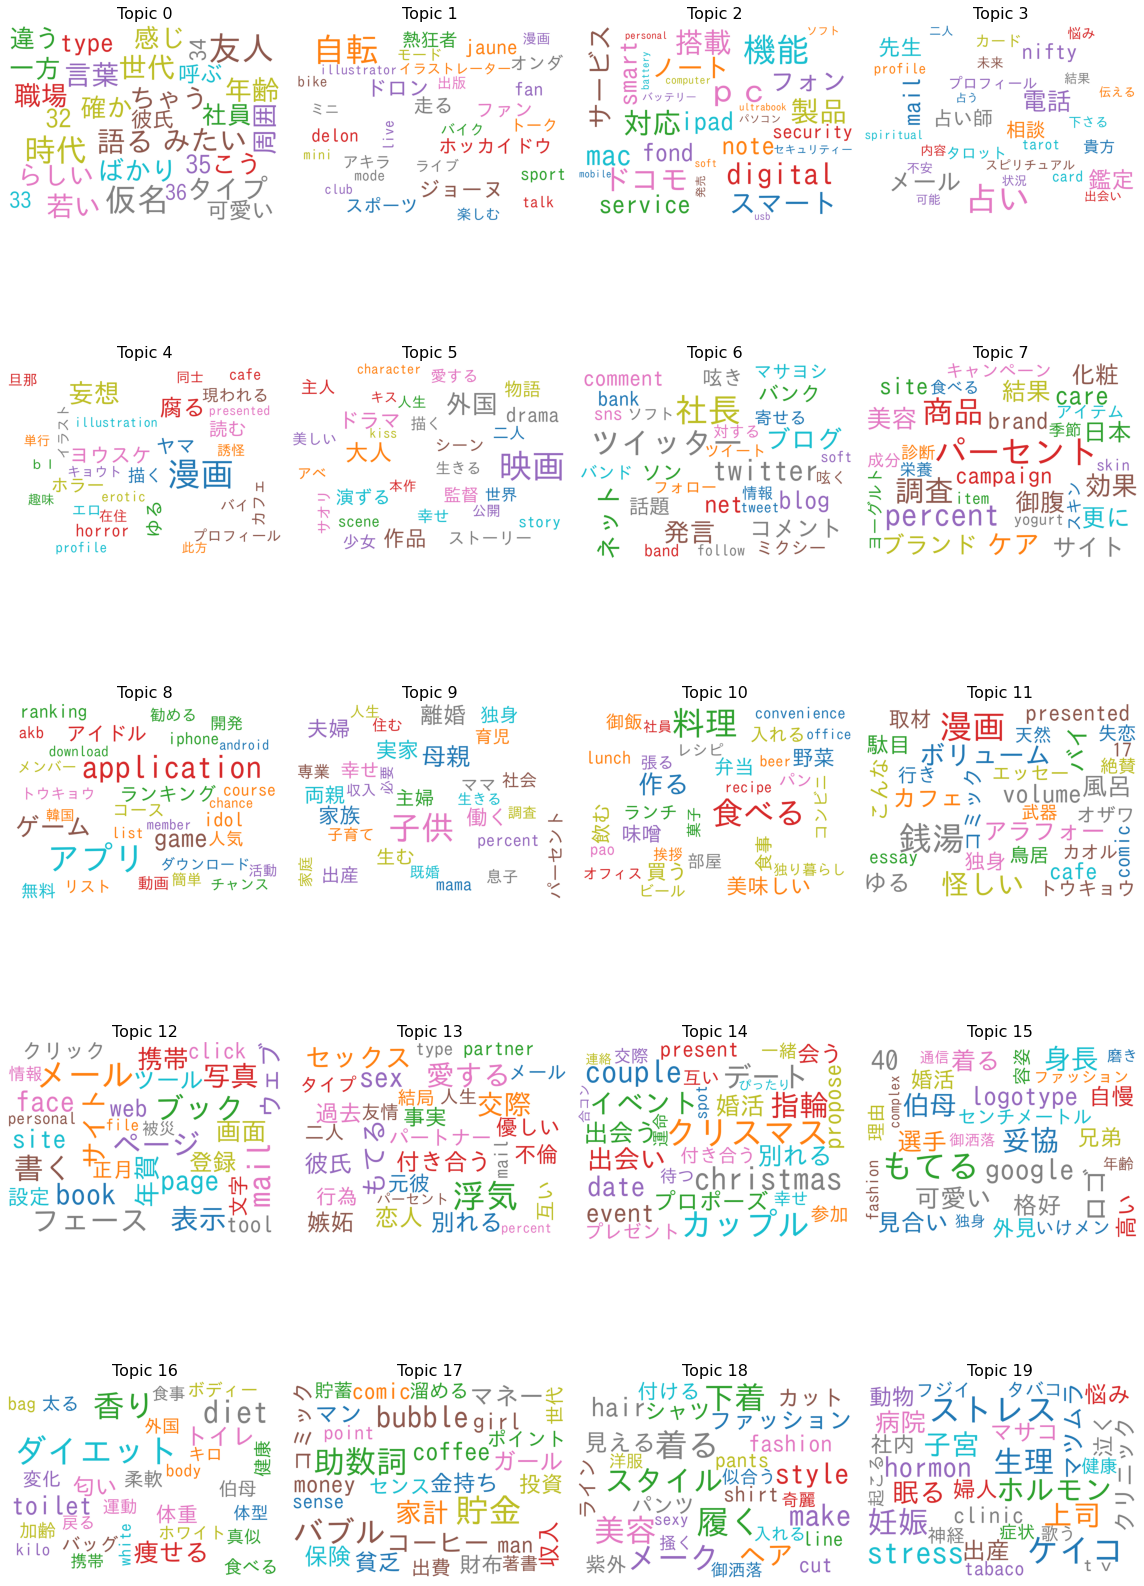

In [35]:
fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 4 scikit-learnのLDAでトピック抽出

### LDAによるトピック抽出の実行

In [36]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=50,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [37]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=1000 and n_features=3855
iteration: 1 of max_iter: 50, perplexity: 7253.5453
iteration: 2 of max_iter: 50, perplexity: 6236.5736
iteration: 3 of max_iter: 50, perplexity: 5631.5119
iteration: 4 of max_iter: 50, perplexity: 5165.9615
iteration: 5 of max_iter: 50, perplexity: 4780.1791
iteration: 6 of max_iter: 50, perplexity: 4451.8384
iteration: 7 of max_iter: 50, perplexity: 4165.7833
iteration: 8 of max_iter: 50, perplexity: 3914.0721
iteration: 9 of max_iter: 50, perplexity: 3691.7259
iteration: 10 of max_iter: 50, perplexity: 3493.5106
iteration: 11 of max_iter: 50, perplexity: 3318.7262
iteration: 12 of max_iter: 50, perplexity: 3163.2014
iteration: 13 of max_iter: 50, perplexity: 3026.0083
iteration: 14 of max_iter: 50, perplexity: 2905.3517
iteration: 15 of max_iter: 50, perplexity: 2799.2757
iteration: 16 of max_iter: 50, perplexity: 2706.2014
iteration: 17 of max_iter: 50, perplexity: 2624.8172
iteration: 18 of max_iter: 50, perpl

### LDAの各トピックから高確率語を取り出す

In [38]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [39]:
print(top_words[0])

['写真', 'ツイッター', 'twitter', 'ネット', 'net', 'file', 'ファイル', '表示', '情報', '設定', 'page', 'ページ', 'ブック', 'book', 'blog', 'ブログ', '妄想', '社長', 'フェース', 'face', '画面', 'データ', 'data', '利用', 'computer', 'personal', 'ソフト', 'google', 'soft', 'パソコン']


In [40]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [41]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf',
                  colormap='tab10'
                  )

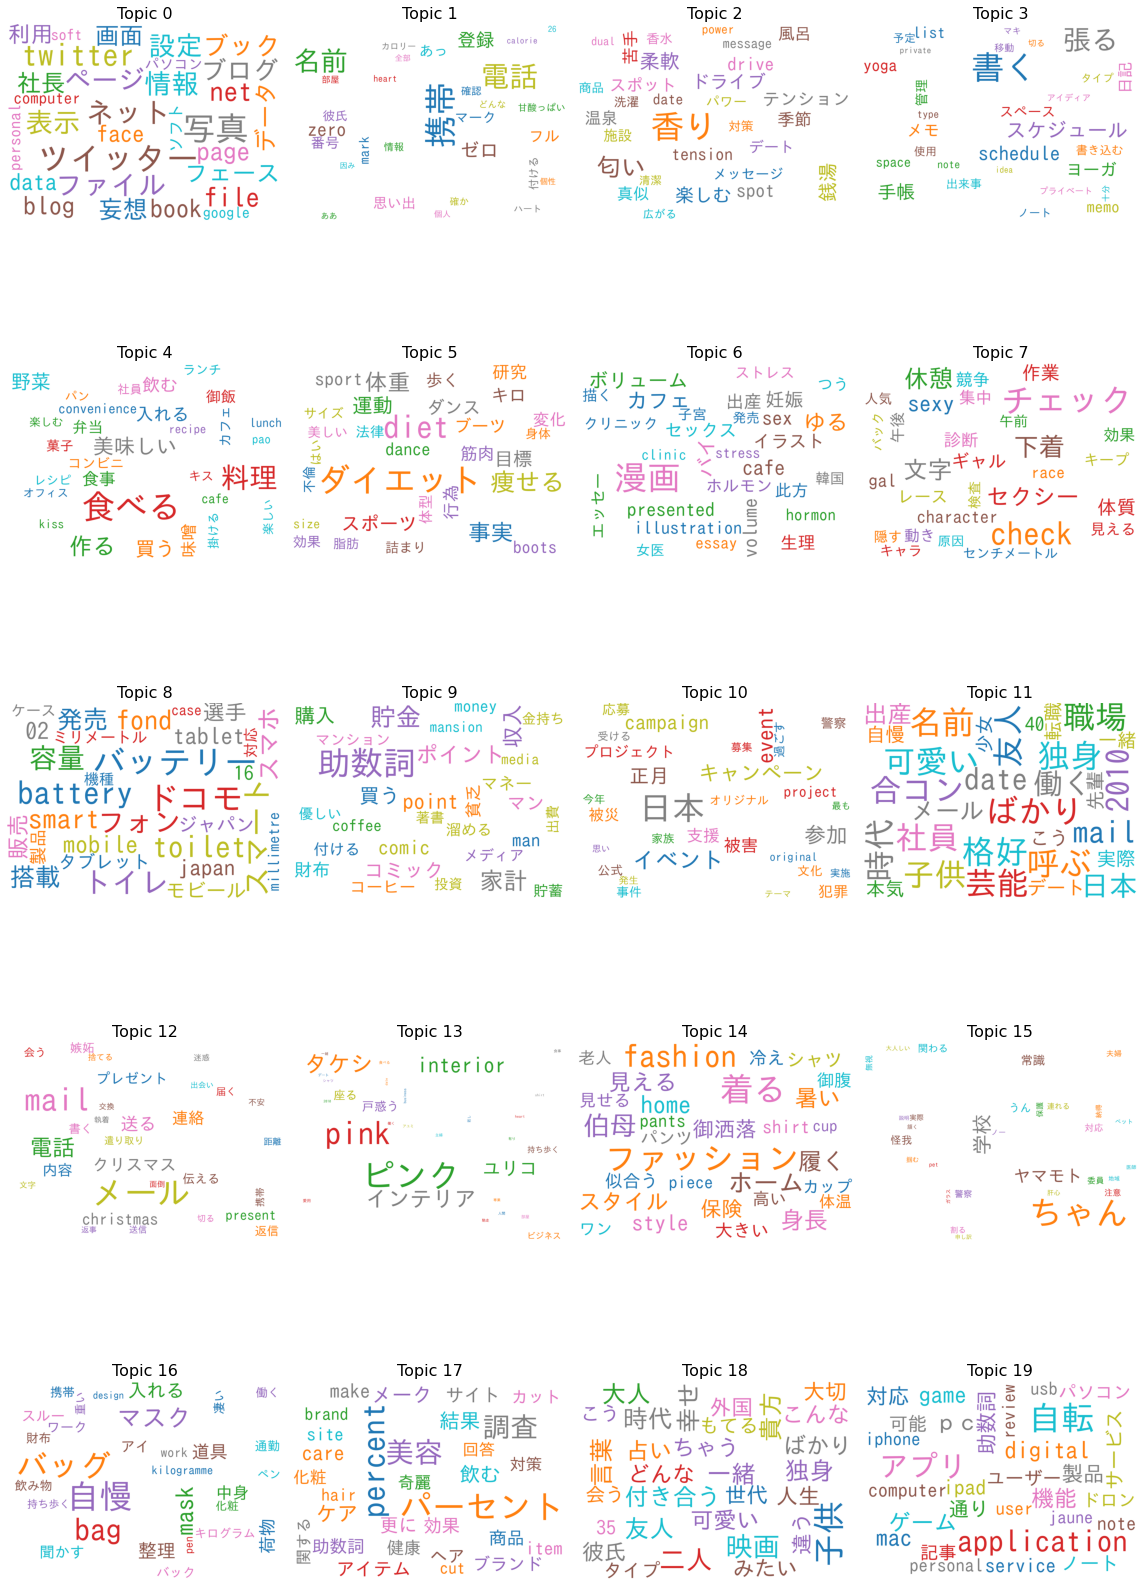

In [42]:
fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

### pyLDAvisという可視化ツールでトピックを可視化
* https://pyldavis.readthedocs.io/en/latest/

In [43]:
!pip install pyLDAvis

In [44]:
import pyLDAvis
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [45]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
18     -10.878068   10.538728       1        1  53.062137
19     -60.884026  -75.591820       2        1  11.519754
0       -2.336119  -53.289074       3        1   8.113406
17     -61.385319  -12.914634       4        1   5.939931
4      -28.737743  126.296997       5        1   4.630848
6        1.066606 -123.552811       6        1   2.968257
14      45.140720   -7.947869       7        1   2.495978
8     -140.795975  -98.530548       8        1   2.179899
12      61.531681  -83.240562       9        1   1.833450
9      -72.563057 -140.396881      10        1   1.689169
5       15.984491   63.578186      11        1   1.362195
10    -160.851624   68.945145      12        1   0.990546
2       85.961830   51.922935      13        1   0.840137
7      -99.020836  109.936348      14        1   0.779969
1     -176.764130   -8.681684      15        1   0.466261
16    -117.189880  -37.420200      16        1   0.458125
3      108.829918  -22.946203      17        1   0.327670
15      47.588097  121.934814      18        1   0.232405
13    -106.467834   30.176889      19        1   0.086101
11     -50.613804   59.328842      20        1   0.023761, topic_info=      Term        Freq       Total Category  logprob  loglift
2673    日本  535.000000  535.000000  Default  30.0000  30.0000
1345   メール  503.000000  503.000000  Default  29.0000  29.0000
361   mail  503.000000  503.000000  Default  28.0000  28.0000
3763    電話  359.000000  359.000000  Default  27.0000  27.0000
696    ちゃん  234.000000  234.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
1345   メール    0.013793  503.895479  Topic20  -8.1903  -2.1611
3807   飲み会    0.013514   66.990744  Topic20  -8.2107  -0.1637
2208    実際    0.013650  234.373418  Topic20  -8.2007  -1.4061
657     こう    0.013591  299.870645  Topic20  -8.2050  -1.6568
1444    一緒    0.013584  374.659276  Topic20  -8.2055  -1.8800

[1055 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2         1  0.367675   02
2         2  0.136565   02
2         3  0.115555   02
2         4  0.078788   02
2         5  0.015758   02
...     ...       ...  ...
3845      3  0.964436   ｂｌ
3848      3  1.002226   ｇｂ
3852      2  0.630494   ｐｃ
3852      3  0.358235   ｐｃ
3852      4  0.009553   ｐｃ

[3073 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 20, 1, 18, 5, 7, 15, 9, 13, 10, 6, 11, 3, 8, 2, 17, 4, 16, 14, 12])

## 05 gensimのLDAでトピック抽出

* **問題点１** gensimのLdaModelはデフォルトの設定だと正しく動かない
 * passesを20ぐらいにはしておくこと。
 * WebにあるgensimのLDAの解説で、passesをデフォルトの1のまま動かしているものが多い。
* 問題点2 gensimのperplexityはトークンあたりのELBOのnp.exp2()で求めている
 * 自然対数の底を使って求めたELBOをもとにして計算しているにもかかわらず。


### gensimに特有の前処理

In [46]:
from gensim import corpora

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### 辞書を作成

In [47]:
dictionary = corpora.Dictionary(new_docs)

In [48]:
print(dictionary)

Dictionary(20986 unique tokens: ['00', '05', '0900', '10', '1000']...)


### 低頻度語と高頻度語を除く

In [49]:
dictionary.filter_extremes(no_below=10, no_above=0.25)

In [50]:
len(dictionary)

3360

### gensim用コーパスを作成

In [51]:
gs_corpus = [dictionary.doc2bow(doc) for doc in new_docs]

In [52]:
print(gs_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 1), (17, 4), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 3), (38, 1), (39, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 6), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 2), (80, 1), (81, 2), (82, 1), (83, 2), (84, 2), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 2), (94, 2), (95, 1), (96, 1), (97, 1), (98, 3), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1),

### ロギングの設定
* ここではログはファイルに書き出すことにする。

In [53]:
import logging
logging.basicConfig(filename='myapp.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

* gensimが微妙に新しいNumPyに対応していなかったりしてwarningがとてもたくさん出るため、それを無視する。

In [54]:
import warnings
warnings.filterwarnings("ignore")

### LDAでトピック抽出

In [55]:
from gensim.models.ldamodel import LdaModel

* scikit-learnと流儀が違うので注意。
* gensimではモデルのインスタンスを作ることが、トピック抽出の計算の開始を意味する。
 * gensimにfitメソッドは無い。

In [56]:
lda = LdaModel(corpus=gs_corpus, num_topics=n_components,
               passes=50)

### gensimの計算結果を元に正しいperplexityを求める
* ログに書き出されているperplexityはexp2を使っているので、注意。

In [57]:
import numpy as np

np.exp(- lda.log_perplexity(gs_corpus))

1796.9309958006397

### coherenceによるトピックの質の評価
* これはscikit-learnにない機能。
* トピックの高確率語が、リファレンス・コーパスでも頻繁に共起しているなら、coherenceの値は良くなる。
 * ここでは、訓練データそのものをリファレンス・コーパスとしている。

In [58]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=lda, 
                    corpus=gs_corpus, 
                    dictionary=dictionary,
                    coherence='u_mass')

* 全トピックのcoherenceの平均を計算する。

In [59]:
coherence = cm.get_coherence()

In [60]:
coherence

-3.350474301298997

* トピックごとにcoherenceを計算する。

In [61]:
for coherence in cm.get_coherence_per_topic():
    print(coherence)

-6.721442420677049
-2.485605164100571
-1.8413658963448076
-1.727755738517789
-1.9068452687239326
-3.010791035792073
-3.553399135797768
-2.8486303893691853
-4.288991934577384
-1.3819174643152905
-5.559268374811966
-5.449849276382458
-1.7526290132804565
-1.6232154286213383
-1.5470460177134513
-3.503938666051736
-8.9238160297558
-3.6737008183252566
-3.4688621635192955
-1.7404157893023258
